In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

sns.set(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context("talk")
sns.set_palette('Set2', 10)

So, yes, again, I'm trying to show a play-by-play analysis of the Israeli GTFS for SIRI archiving purposes we have at [hasadna/open-bus](https://github.com/hasadna/open-bus).

The agenda this time is: (again, you can skip to item 3 if you're just interested in the stats, or if you already read the previous post):
1. [Get up-to-date GTFS files from the MOT FTP server](#Get-the-data)
2. [Extract the needed info from them into pandas tidy DataFrames](#Tidy-it-up)
2. [Stop and route top charts](#Stop-and-route-top-charts)
4. [On-the-road / concurrency stats](#On-the-road)
5. [A geo teaser :)](#Geo-teaser)
6. [One the next episodes](#On-the-next-episodes) Yep, not all is covered in this notebook

On the pedagogical side, 

## Get the data
We get the data straight from MOT's ftp. Just so I don't repeat the last post, this went out to a separate module.

In [2]:
from gtfs_utils import *

conn = ftp_connect()
ftp_dir = get_ftp_dir(conn)
UPTODATE = 90 #days
our_uptodateness = get_uptodateness(ftp_dir)

if our_uptodateness > UPTODATE:
    get_ftp_file(conn)
    get_ftp_file(conn, file_name = 'Tariff.zip', local_zip_path = 'data/sample/tariff.zip' )

conn.quit()

'221 Goodbye.'

We load MOT's tarrif.txt file, which will give us zone names and other local info.
Found out it's the file is even more fd-up than I realized, so I add the southern zones manualy

In [3]:
tariff_df = extract_tariff_df(local_zip_path = 'data/sample/tariff.zip')
south = [
    {
        'zone_name': 'מצפה רמון',
        'zone_id': '903'
    },
    {
        'zone_name': 'ערבה',
        'zone_id': '902'
    },
    {
        'zone_name': 'אילת',
        'zone_id': '901'
    },]
south = pd.DataFrame(south)
tariff_df = tariff_df.append(south)
tariff_df.tail()

,Daily,FromDate,Monthly,ShareCode,ToDate,Weekly,zone_id,zone_name
72,13.5,01/04/2016 00:00:00,149.0,753.0,01/01/2200 00:00:00,57.5,234,השומרון
73,13.5,01/04/2016 00:00:00,149.0,754.0,01/01/2200 00:00:00,57.5,135,גוש שילה ובקעה
0,NaN,NaN,NaN,NaN,NaN,NaN,903,מצפה רמון
1,NaN,NaN,NaN,NaN,NaN,NaN,902,ערבה
2,NaN,NaN,NaN,NaN,NaN,NaN,901,אילת


## Tidy it up
Again I'm using [partridge](https://github.com/remix/partridge/tree/master/partridge) for filtering on dates, and then some tidying up and transformations.

In [4]:
LOCAL_ZIP_PATH = 'data/sample/gtfs.zip' 

import partridge as ptg

service_ids_by_date = ptg.read_service_ids_by_date(LOCAL_ZIP_PATH)
service_ids = service_ids_by_date[datetime.date(2017, 12, 21)]

feed = ptg.feed(LOCAL_ZIP_PATH, view={
    'trips.txt': {
        'service_id': service_ids,
    },
})

In [5]:
def to_timedelta(df):
    '''
    Turn time columns into timedelta dtype
    '''
    cols = ['arrival_time', 'departure_time']
    numeric = df[cols].apply(pd.to_timedelta, unit='s')
    df = df.copy()
    df[cols] = numeric
    return df

s = feed.stops
r = feed.routes
t = (feed.trips
     .assign(route_id=lambda x: pd.Categorical(x['route_id'])))

f = (feed.stop_times[['trip_id', 'departure_time', 'arrival_time', 'stop_id', 'stop_sequence']]
     .assign(date = datetime.date(2017, 12, 21))
     .merge(s[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'zone_id']], on='stop_id')
     # Much faster joins and slices with Categorical dtypes
     .merge(tariff_df[['zone_id', 'zone_name']], on='zone_id')
     .assign(zone_id=lambda x: pd.Categorical(x['zone_id']))
     .assign(zone_name=lambda x: pd.Categorical(x['zone_name']))
     .merge(t[['trip_id', 'route_id', 'direction_id']], on='trip_id')
     .merge(r[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
     .assign(route_id=lambda x: pd.Categorical(x['route_id']))
     .pipe(to_timedelta)
    )
f.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,date,stop_name,stop_lat,stop_lon,zone_id,zone_name,route_id,direction_id,route_short_name,route_long_name
0,28917380_191217,08:57:00,08:57:00,37312,1,2017-12-21,באר שבע מרכז,31.242886,34.798546,410,באר שבע,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
1,28917380_191217,09:04:00,09:04:00,37314,2,2017-12-21,באר שבע-צפון,31.262089,34.809287,410,באר שבע,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
2,28917380_191217,09:13:00,09:13:00,37308,3,2017-12-21,להבים רהט,31.369907,34.798040,421,רהט להבים,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
3,28917380_191217,09:29:00,09:29:00,37316,4,2017-12-21,קרית גת,31.603526,34.777955,802,קריית גת,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו
4,28917380_191217,09:54:00,09:54:00,37336,5,2017-12-21,רמלה,31.928809,34.877304,210,גוש דן,20950,1,NaN,באר שבע מרכז-באר שבע<->תל אביב מרכז-תל אביב יפו


## On the next episodes
OK, enough for now, on the next posts: 

* TODO: Turn it all to day-of-week means
* TODO: some dynamic bokeh web applet to use this as a tool
* TODO: More geo visualizations
* TODO: More centrality measures
* TODO: Looped routes analysis

## Loops
I want to categorize routes with loops, so I give them 3 categories
1. *"soft-loops"* - only the origin and dest stops are the same
2. *"hard-loops"* - a loop within the route, a stop in the middle

### soft loops
TODO: I added `direction_id` to the groupby, need to check if this is needed


In [26]:
import pickle
import os

In [27]:
# again using a custom groupby aggregation function, this is VERY inefficient,
# but far more readable than doing some other magic, so I'm sticking to it for now

def apply_and_pickle(f, pkl_path, apply_func):
    if not os.path.exists(pkl_path):
        ret_df = f.groupby('trip_id').apply(apply_func)
        # since it's so inefficient I pickle it
        with open(pkl_path, 'wb') as pkl_file:
            pickle.dump(orig_dest_only, pkl_file)
    else:
        with open(pkl_path, 'rb') as pkl_file:
            ret_df = pickle.load(pkl_file)
        return ret_df

In [ ]:
def first_last(df):
    return df.sort_values(by='stop_sequence').iloc[[0, -1]]
orig_dest_only = apply_and_pickle(f, 'softloop_test.pkl', first_last)

In [118]:
gr = orig_dest_only.groupby(['route_id', 'trip_id', 'stop_id', 'direction_id']).size()
r[r.route_id.isin(gr[gr>1].reset_index().groupby('route_id').trip_id.nunique().pipe(lambda x: x[x>0]).index)].shape

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'trip_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


(114, 7)

### All loops

In [86]:
gr = f.groupby(['route_id', 'trip_id', 'stop_id']).size()
gr[gr>1].reset_index().groupby('route_id').trip_id.nunique().pipe(lambda x: x[x>0]).shape

(644,)

### Hard loops
Divide this into two with first or with last.
#### With first

In [89]:
def first_to_before_last(df):
    return df.sort_values(by='stop_sequence').iloc[0:-1]

apply_and_pickle(f, 'hard_with_first.pkl', first_to_before_last)

In [106]:
gr = hard_with_first.groupby(['route_id', 'trip_id', 'stop_id']).size()
r[r.route_id.isin(gr[gr>1].reset_index().groupby('route_id').trip_id.nunique().pipe(lambda x: x[x>0]).index)]

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'trip_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color
22,12479,2,NaN,מודיעין מרכז-מודיעין מכבים רעות<->תל אביב מרכז...,26025-2-0,2,NaN
23,18899,2,NaN,תל אביב מרכז-תל אביב יפו<->מודיעין מרכז-מודיעי...,26025-1-2,2,NaN
28,20177,2,NaN,נהריה-נהריה<->מודיעין מרכז-מודיעין מכבים רעות,26050-1-23,2,NaN
29,20179,2,NaN,מודיעין מרכז-מודיעין מכבים רעות<->נהריה-נהריה,26050-2-20,2,NaN
30,20180,2,NaN,נהריה-נהריה<->מודיעין מרכז-מודיעין מכבים רעות,26050-1-24,2,NaN
31,20182,2,NaN,נהריה-נהריה<->מודיעין מרכז-מודיעין מכבים רעות,26050-1-25,2,NaN
35,20953,2,NaN,מודיעין מרכז-מודיעין מכבים רעות<->נהריה-נהריה,26050-2-24,2,NaN
36,20954,2,NaN,נהריה-נהריה<->מודיעין מרכז-מודיעין מכבים רעות,26050-1-28,2,NaN
37,20955,2,NaN,מודיעין מרכז-מודיעין מכבים רעות<->נהריה-נהריה,26050-2-25,2,NaN
38,20956,2,NaN,מודיעין מרכז-מודיעין מכבים רעות<->נהריה-נהריה,26050-2-26,2,NaN


#### With last

In [91]:
def second_to_last(df):
    return df.sort_values(by='stop_sequence').iloc[1:]

apply_and_pickle(f, 'hard_with_last.pkl', second_to_last)

In [93]:
gr = hard_with_last.groupby(['route_id', 'trip_id', 'stop_id']).size()
gr[gr>1].reset_index().groupby('route_id').trip_id.nunique().pipe(lambda x: x[x>0]).shape

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'trip_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


(543,)

#### No origin and dest, only middle stops

In [99]:
def middle(df):
    return df.sort_values(by='stop_sequence').iloc[1:-1]

apply_and_pickle(f, 'middle.pkl', middle)

In [100]:
gr = hard_with_last.groupby(['route_id', 'trip_id', 'stop_id']).size()
gr[gr>1].reset_index().groupby('route_id').trip_id.nunique().pipe(lambda x: x[x>0]).shape

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'trip_id' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


(543,)

### Loops think-over
http://gtfs.org/best-practices/, two definitions relevant to our review today - **Loop routes** and **Lasso Routes**.

Start by finding both

In [20]:
stop_seq_counts = f.groupby(['trip_id', 'route_id', 'stop_id']).stop_sequence.nunique()
looped_routes = stop_seq_counts[stop_seq_counts>1].reset_index().groupby('route_id').size()
looped_routes = looped_routes[looped_routes>0]

In [24]:
r[r.route_id.isin(looped_routes.index)]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color
167,3575,3,6,קיבוץ גלויות/הקטר-חיפה<->קיבוץ גלויות/הקטר-חיפ...,10006-3-#,3,NaN
174,3600,3,10,חסן שוקרי/הנביאים-חיפה<->חסן שוקרי/הנביאים-חיפ...,10010-3-#,3,NaN
175,3601,3,11,גיבורי התהילה/בית קמה-כפר חסידים א'<->גיבורי ה...,10011-3-#,3,NaN
207,3662,3,20,ערד/סובה-חיפה<->ערד/סובה-חיפה-3#,10020-3-#,3,NaN
225,19615,3,29,תחנה מרכזית חוף כרמל/רציפים עירוני-חיפה<->תחנה...,10029-3-#,3,NaN
235,19617,3,32,דרך צרפת/יצחק נדב-חיפה<->דרך צרפת/יצחק נדב-חיפ...,10032-3-#,3,NaN
236,3743,3,33,הנשיא/מרכז פנורמה-חיפה<->הנשיא/מרכז פנורמה-חיפ...,10033-3-#,3,NaN
239,3748,3,34,הנשיא/מרכז פנורמה-חיפה<->הנשיא/מרכז פנורמה-חיפ...,10034-3-#,3,NaN
240,3750,3,34,הנשיא/מרכז פנורמה-חיפה<->בן גוריון/המגינים-חיפ...,10034-3-ה,3,FF9933
257,3782,3,38,הגליל/מאירוביץ-חיפה<->הגליל/מאירוביץ-חיפה-3#,10038-3-#,3,NaN


### How many final stops?

In [23]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

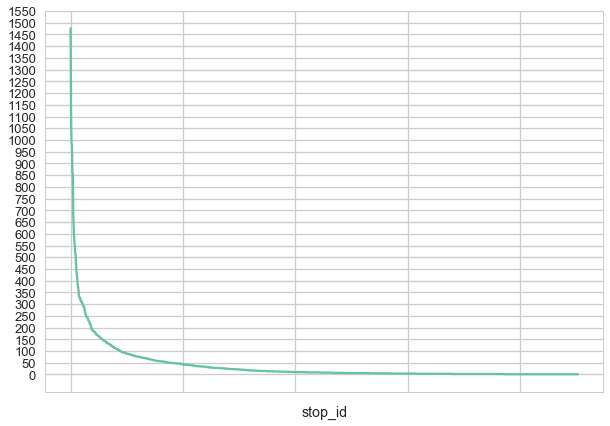

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_yticks(np.arange(32)*50)
orig_dest_only[orig_dest_only.stop_sequence!=1].groupby('stop_id').size().sort_values(ascending=False).plot(ax=ax)

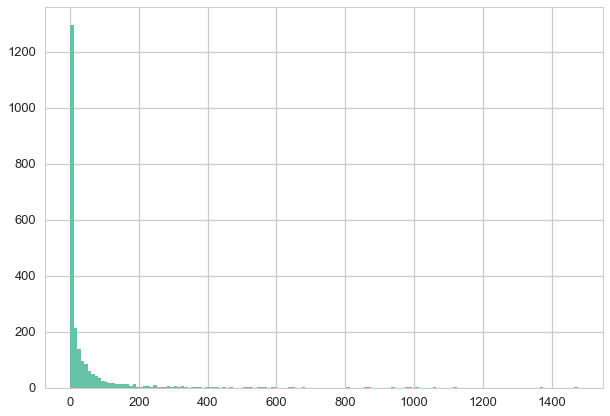

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
orig_dest_only[orig_dest_only.stop_sequence!=1].groupby('stop_id').size().sort_values(ascending=False).hist(bins=147, ax=ax)

In [12]:
orig_dest_only[orig_dest_only.stop_sequence!=1].groupby('stop_id').size().sum()

92384

In [19]:
t.shape

(89777, 6)

In [25]:
f[f.stop_sequence==1].shape

(89105, 15)